<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Dataset Exercises</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/%s/Brain2022/" % os.environ['USERNAME']

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

# this path should point to the location of the dataset on your platform
#cache_dir = r"/Volumes/programs/mindscope/workgroups/np-behavior/vbn_data_release/vbn_s3_cache"
# cache_dir = '/home/praveen/data/vb_np_cache/'
cache_dir = '\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache'

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=cache_dir)

/home/praveen/.anaconda3/envs/allensdk_38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-block alert-info">

## Exercise 1: Examining licking behavior

In this exercise, we'll examine the licking behavior of the mouse

1. Comparing lick times for hit trials and aborted trials
1. Comparing lick latency from the stimulus flash for hit trials and aborted/false alarm trials
1. Computing lick bouts

</div>

In [4]:
# Setup: first, let's get the relevant tables
session_id = 1053941483
session = cache.get_ecephys_session(ecephys_session_id=session_id)

stimulus_presentations = session.stimulus_presentations
trials = session.trials
licks = session.licks

/home/praveen/.anaconda3/envs/allensdk_38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div class="alert alert-block alert-success">

### 1.1 Comparing lick times for hit trials and aborted trials

We'll start by comparing the time between the start of the trial and the point at which the mouse licked, in aborted trials and in hit trials.

Since the mouse correctly waited until the stimulus changed in hit trials, the wait time distribution should closely match the distribution of change times. On the other hand, the distribution of lick times should be much smaller in the case of aborted trials.

</div>

In [5]:
# First, we need to find the first lick in each trial.
# To do this, we have to identify which trial each lick falls in
trial_indices = np.searchsorted(trials['stop_time'], licks['timestamps'])

# Add the trial index to the licks table as a new column
licks['trials_id'] = trial_indices
licks.head()

,timestamps,frame,trials_id
0,25.72309,91,0
1,25.85921,100,0
2,28.01198,229,1
3,32.39186,491,2
4,35.52050,679,3


In [6]:
# Find the first lick in each trial, by grouping licks by trial index
first_licks = licks[['timestamps', 'trials_id']].groupby('trials_id').agg('min')
first_licks.head()

,timestamps
trials_id,
0,25.72309
1,28.01198
2,32.39186
3,35.52050
4,39.15059


In [7]:
# Now that we have the time stamp of the first lick in each trial, we can add this information to the trials table
trials_with_first_licks = pd.merge(trials, first_licks, how='left', on='trials_id')

# Compute the time from the start of the trial to the first lick
trials_with_first_licks['trial_start_to_first_lick'] = trials_with_first_licks['timestamps'] - trials_with_first_licks['start_time']
trials_with_first_licks.head()

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,...,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,timestamps,trial_start_to_first_lick
trials_id,,,,,,,,,,,,,,,,,,,,,
0,25.20983,26.19343,im104_r,im104_r,False,NaN,False,False,"[25.72637, 25.87602]",NaN,...,False,False,False,False,True,False,NaN,0.98360,25.72309,0.51326
1,26.71046,28.34528,im104_r,im104_r,False,NaN,False,False,[28.02817],NaN,...,False,False,False,False,True,False,NaN,1.63482,28.01198,1.30152
2,28.96234,32.73245,im104_r,im104_r,False,NaN,False,False,[32.39844],NaN,...,False,False,False,False,True,False,NaN,3.77011,32.39186,3.42952
3,33.46618,35.85175,im104_r,im104_r,False,NaN,False,False,[35.53463],NaN,...,False,False,False,False,True,False,NaN,2.38557,35.52050,2.05432
4,36.46863,39.62138,im104_r,im104_r,False,NaN,False,False,"[39.15441, 39.28716]",NaN,...,False,False,False,False,True,False,NaN,3.15275,39.15059,2.68196


In [8]:
# Sub-select only the hit trials and the aborted trials.
hit_aborted_trials = trials_with_first_licks.query('hit == True or aborted == True').copy()
# We call .copy() after querying to prevent the SettingWithCopy warning.

# Then, make a new column indicating the trial type ('hit', or 'aborted').
# This step will be useful for plotting with seaborn
hit_aborted_trials['trial_type'] = 'hit'
hit_aborted_trials.loc[hit_aborted_trials['aborted'] == True, 'trial_type'] = 'aborted'

<AxesSubplot:xlabel='trial_start_to_first_lick', ylabel='Count'>

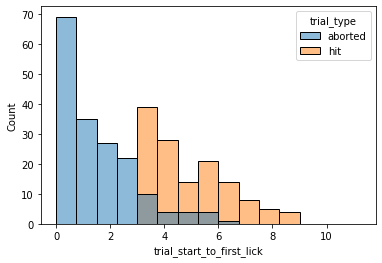

In [9]:
# Plot a histogram of the time from the start of the trial to the first lick, colored by trial type
sns.histplot(hit_aborted_trials, x='trial_start_to_first_lick', hue='trial_type', bins=np.arange(0, 12, 0.75))

<div class="alert alert-block alert-success">

### 1.2  Comparing lick latency from the stimulus flash for hit trials and aborted/false alarm trials

Next, let's compare the latency between the first lick and the preceding stimulus flash across hit, aborted and false alarm trials.
    
# Write something about what we expect to see -------------------------------------
    
</div>

In [10]:
# We have already added time stamps of first licks to the trials table in Exercise 1.1.

# For hit trials, we can use the change_time column from the trials table to determine the time at which
# the image changed, but for aborted trials, the change never happens, so the change_time would be NaN.

# To find the stimulus flash just before the lick for all trials, we'll need to look at the
# stimulus_presentations table, and merge it with the trials table.
stimulus_presentations['trials_id'] = np.searchsorted(trials_with_first_licks['start_time'], stimulus_presentations['start_time']) - 1
stim_pres_with_trials = stimulus_presentations.merge(trials_with_first_licks, how='left', on='trials_id', suffixes=('_stim', '_trial'))
# While merging, note that both the stimulus_presentations table and the trials table have columns of the same name, e.g., start_time
# To distinguish them after merging, we use the suffixes provided to the merge function.
# Default suffixes are ('_x', '_y'), but it's better to rename them to be more meaningful.

# Now that we have all the info we need, let's start by subselecting the hit, false alarm and aborted trials
stim_pres_hit_fa_aborted = stim_pres_with_trials.query('hit == True or false_alarm == True or aborted == True')

# Next, let's select the stimulus presentations that precede the lick timestamp
stim_pres_prec_first_lick = stim_pres_hit_fa_aborted.query('start_time_stim < timestamps').copy()

# To find the stimulus presentation *just* before the lick, we can group these by trial index and select the
# stimulus presentation with the largest stimulus presentation index.
# We'll first create a new column called stim_id to contain the stimulus presentation index
temp_df = stim_pres_prec_first_lick.reset_index().rename(columns={'index': 'stim_id'})
# Then, we can perform the group-by and find the maximum stim_id in each trial
last_stim_id_in_each_trial = temp_df[['stim_id', 'trials_id']].groupby('trials_id').agg('max')
# Finally, we can choose those rows from the combined stimulus_presentation-trials-first_licks table 
# that have these stim_id's.
stim_pres_prec_first_lick = stim_pres_prec_first_lick.loc[last_stim_id_in_each_trial['stim_id']]
stim_pres_prec_first_lick.head()

# Note: there's also an easier way to do this, using searchsorted to directly find the stimulus presentations
# preceding the first lick in each trial.

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,timestamps,trial_start_to_first_lick
0,True,NaN,NaN,0.250212,75,0.0,im104_r,False,False,NaN,...,False,False,False,False,True,False,NaN,0.98360,25.72309,0.51326
3,True,NaN,NaN,0.250207,210,3.0,im104_r,False,False,NaN,...,False,False,False,False,True,False,NaN,1.63482,28.01198,1.30152
9,True,NaN,NaN,0.250205,480,8.0,im104_r,False,False,NaN,...,False,False,False,False,True,False,NaN,3.77011,32.39186,3.42952
13,True,NaN,NaN,0.250205,660,12.0,im104_r,False,False,NaN,...,False,False,False,False,True,False,NaN,2.38557,35.52050,2.05432
18,True,NaN,NaN,0.250208,885,17.0,im104_r,False,False,NaN,...,False,False,False,False,True,False,NaN,3.15275,39.15059,2.68196


<AxesSubplot:xlabel='lick_latency', ylabel='Count'>

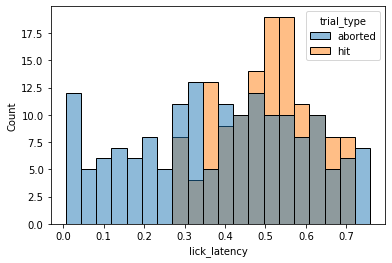

In [11]:
# Now, we can compute the latency between the first lick and the start of the preceding stimulus flash
stim_pres_prec_first_lick['lick_latency'] = stim_pres_prec_first_lick['timestamps'] - stim_pres_prec_first_lick['start_time_stim']

# Finally, let's pull out the relevant columns for plotting
lick_latencies_to_plot = stim_pres_prec_first_lick[['lick_latency', 'hit', 'false_alarm', 'aborted']].copy()

lick_latencies_to_plot['trial_type'] = 'hit'
lick_latencies_to_plot.loc[lick_latencies_to_plot['false_alarm'], 'trial_type'] = 'false_alarm'
lick_latencies_to_plot.loc[lick_latencies_to_plot['aborted'], 'trial_type'] = 'aborted'

sns.histplot(lick_latencies_to_plot, x='lick_latency', hue='trial_type', bins=20)

<div class="alert alert-block alert-success">

### 1.3  Computing lick bouts

Mice tend to lick quickly in rapid succession. In this exercise, we'll examine how to separate these licks into lick "bouts".
    
</div>

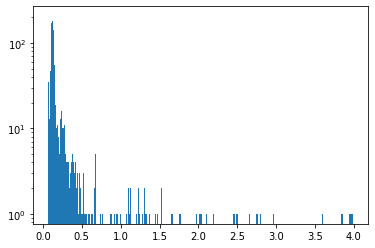

In [12]:
# Compute the inter-lick interval from the licks table
ili = np.diff(licks['timestamps'])  # Inter-lick interval

# Plot a histogram of the inter-lick interval to find a reasonable threshold for lick bouts
# Use log scaling on the y-axis to better evaluate where the lick bout cuts off
fig = plt.figure()
h = plt.hist(ili[ili < 4], bins=1000)
ax = plt.gca()
ax.set_yscale('log')

In [13]:
# Set the lick bout threshold based on where the histogram clips off (roughly)
lick_bout_threshold = 0.6

# Add the inter-lick interval to the licks table (not needed for what follows)
licks['time_from_last_lick'] = np.concatenate(([np.inf], ili))

# Create a lick-bout column in the licks table, which tells you the "bout index" that each
# lick is part of: to compute the bout index, we need to increment a counter every time the
# inter-lick interval exceeds the lick_bout_threshold that we defined above.
# np.cumsum computes a cumulative sum, and helps us do this efficiently.
licks['lick_bout'] = 0
licks.iloc[1:, licks.columns.get_indexer(['lick_bout'])] = np.cumsum((ili > lick_bout_threshold).astype(int))
licks.head()

,timestamps,frame,trials_id,time_from_last_lick,lick_bout
0,25.72309,91,0,inf,0
1,25.85921,100,0,0.13612,0
2,28.01198,229,1,2.15277,1
3,32.39186,491,2,4.37988,2
4,35.52050,679,3,3.12864,3


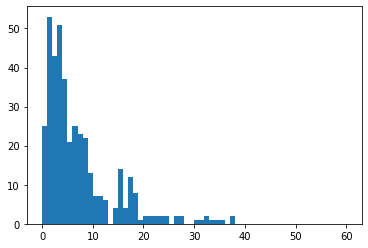

In [14]:
# Create a table with the timestamps of lick bouts, i.e., timestamps of the first lick in each bout
lick_bouts = licks[['timestamps', 'lick_bout']].groupby('lick_bout').agg('min')
inter_bout_interval = np.diff(lick_bouts['timestamps'])

# Check what the histogram of inter-bout intervals looks like
# (leaving out intervals >=1 minute in length)
plt.figure()
_ = plt.hist(inter_bout_interval[inter_bout_interval < 60], bins=np.arange(61))